Trabajaremos con datos
de clientes de un centro comercial que incluyen sus ingresos anuales e √≠ndices de gastos.

**Objetivo**

Agrupar a los
clientes en diferentes cl√∫steres bas√°ndonos en su comportamiento de compra.

‚Ä¢ Visualizaremos los cl√∫steres resultantes en un diagrama de dispersi√≥n, diferenciando a los clientes seg√∫n su agrupaci√≥n.

Me he apoyado tanto en el EDA como en el codigo en la herramienta de **Estudio LM** usando un modelo
Deepseek R1 0528 Qwen3 8B al cual le hice un rag con este documento oficial del gobierno de Espa√±a https://datos.gob.es/sites/default/files/doc/file/analisis_exploratorio_de_datos_2021.pdf.

Dado que en un caso "real" la informaci√≥n del dataset se mantendr√≠a en local siendo m√°s seguro para la empresa y con el RAG nos asegurar√≠amos que nos arrojase el modelo la informaci√≥n tal como la necesitamos


Aunque s√© que este curso no es de IA generativa me pareci√≥ interesante utilizar este recurso.


Como observaci√≥n, el modelo no fue capaz de darme tan bien detalles de EDA o del codigo como Cloud Sonet 4 o cualquiera de OpenIA.



In [4]:
#Importaciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configuraci√≥n de visualizaci√≥n
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Modelo


from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.preprocessing import MinMaxScaler



In [5]:
# Cargar datos
df = pd.read_csv('Mall_Customers.csv')
print(df.head())
print ("*"*50)
print(df.info())
print ("*"*50)
print("Tipos de datos")
print(df.dtypes)
print ("*"*50)
print("Nombres de columnas:")
print(df.columns.tolist())

   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None


**Podemos observar que tenemos un dataset de 200 entradas(bastante poco), el cual tiene 5 columnas CustomerID', 'Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)', en las cuales no existen valores nulos**

**Todos los valores son del tipo num√©rico entero excepto la categor√≠a de g√©nero que es object, lo cual se mapear√° m√°s adelante**

In [6]:
print("\nEstad√≠sticas descriptivas - Variables num√©ricas:")
numeric_cols = df.select_dtypes(include=[np.number]).columns
print(df[numeric_cols].describe().round(2))

print("\n Estad√≠sticas descriptivas - Variable categ√≥rica (Genre):")
print(df['Genre'].value_counts())
print(f"\nPorcentaje por g√©nero:")
print((df['Genre'].value_counts(normalize=True) * 100).round(2))


Estad√≠sticas descriptivas - Variables num√©ricas:
       CustomerID     Age  Annual Income (k$)  Spending Score (1-100)
count      200.00  200.00              200.00                  200.00
mean       100.50   38.85               60.56                   50.20
std         57.88   13.97               26.26                   25.82
min          1.00   18.00               15.00                    1.00
25%         50.75   28.75               41.50                   34.75
50%        100.50   36.00               61.50                   50.00
75%        150.25   49.00               78.00                   73.00
max        200.00   70.00              137.00                   99.00

 Estad√≠sticas descriptivas - Variable categ√≥rica (Genre):
Genre
Female    112
Male       88
Name: count, dtype: int64

Porcentaje por g√©nero:
Genre
Female    56.0
Male      44.0
Name: proportion, dtype: float64


En este estudio podemos ver que hay m√°s datos recogidos de mujeres que de hombres, y la edad promedio es de 38 a√±os, as√≠ como el gasto promedio es de $50

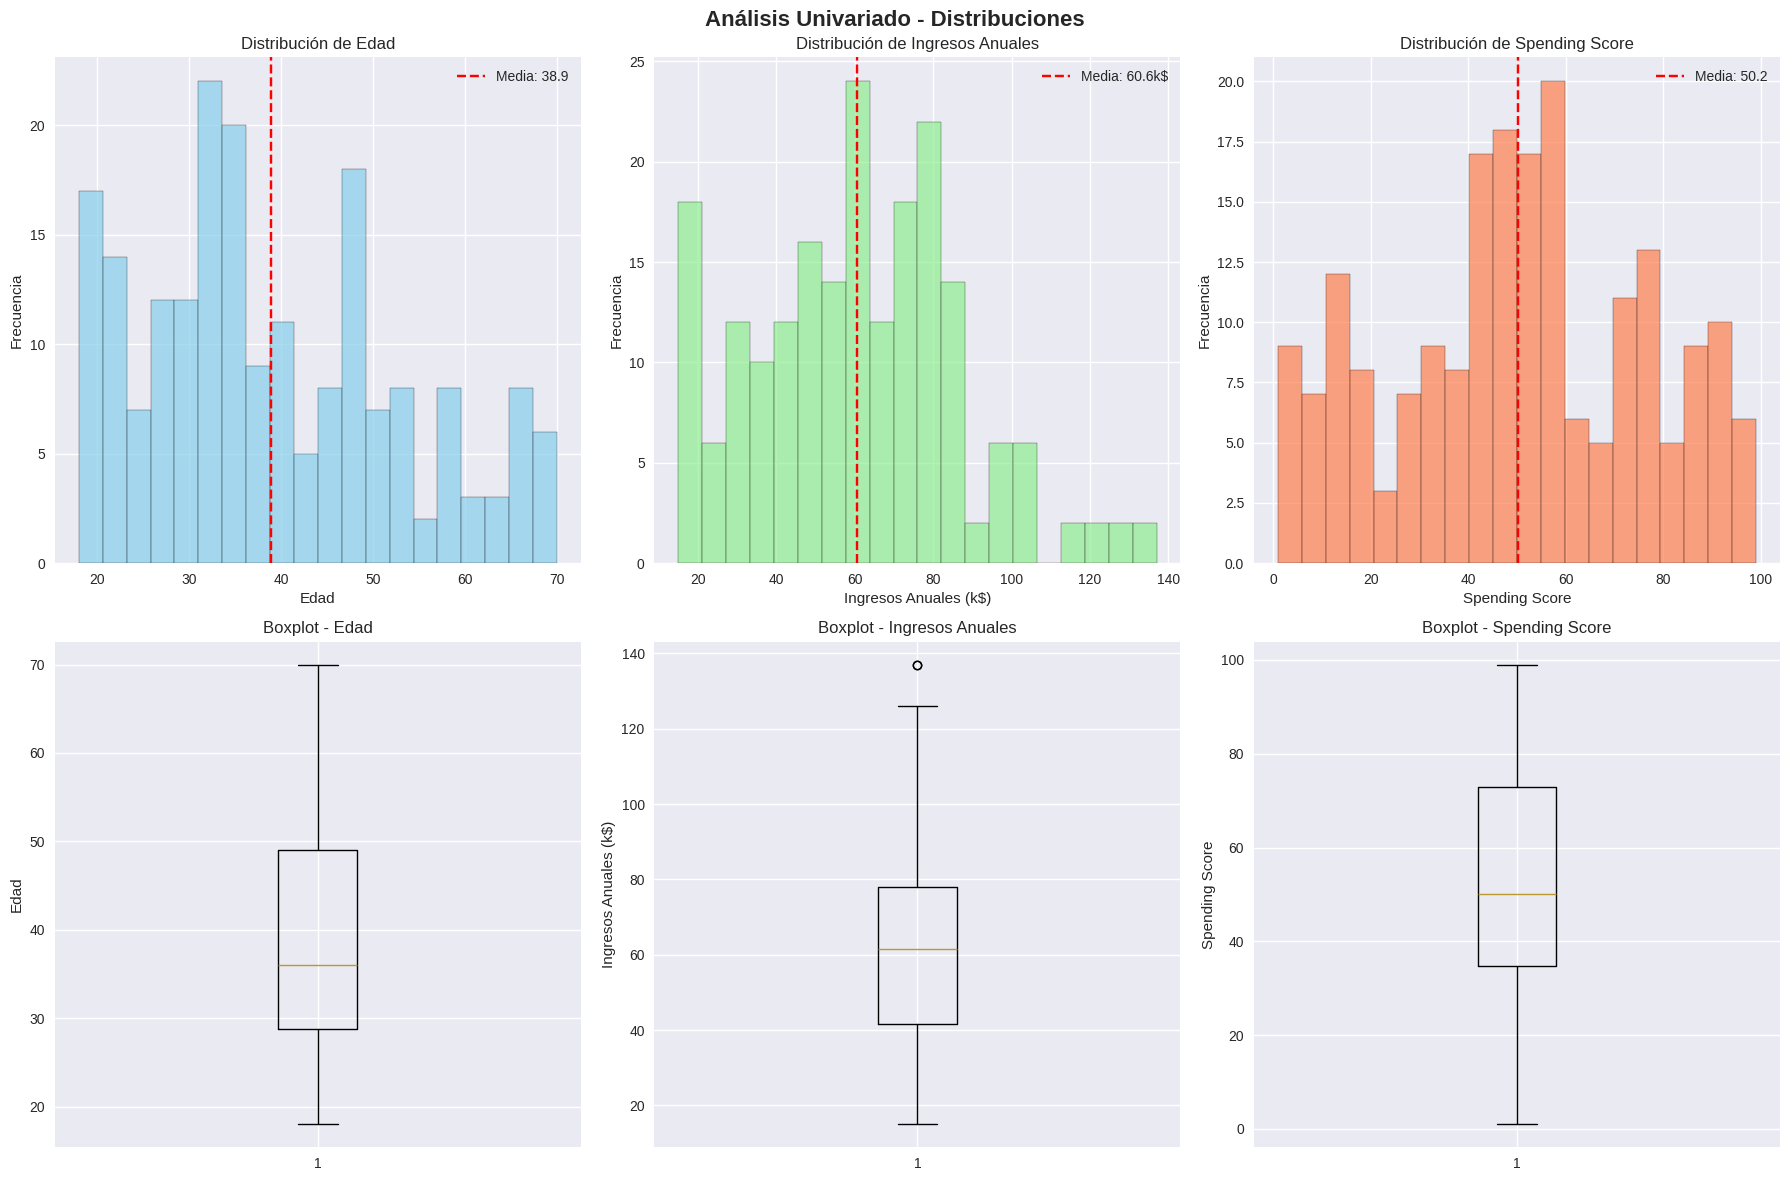

In [7]:

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('An√°lisis Univariado - Distribuciones', fontsize=16, fontweight='bold')


# Distribuci√≥n de Edad
axes[0,0].hist(df['Age'], bins=20, edgecolor='black', alpha=0.7, color='skyblue')
axes[0,0].set_title('Distribuci√≥n de Edad')
axes[0,0].set_xlabel('Edad')
axes[0,0].set_ylabel('Frecuencia')
axes[0,0].axvline(df['Age'].mean(), color='red', linestyle='--', label=f'Media: {df["Age"].mean():.1f}')
axes[0,0].legend()

# Distribuci√≥n de Ingresos Anuales
axes[0,1].hist(df['Annual Income (k$)'], bins=20, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0,1].set_title('Distribuci√≥n de Ingresos Anuales')
axes[0,1].set_xlabel('Ingresos Anuales (k$)')
axes[0,1].set_ylabel('Frecuencia')
axes[0,1].axvline(df['Annual Income (k$)'].mean(), color='red', linestyle='--',
                  label=f'Media: {df["Annual Income (k$)"].mean():.1f}k$')
axes[0,1].legend()

# Distribuci√≥n de Spending Score
axes[0,2].hist(df['Spending Score (1-100)'], bins=20, edgecolor='black', alpha=0.7, color='coral')
axes[0,2].set_title('Distribuci√≥n de Spending Score')
axes[0,2].set_xlabel('Spending Score')
axes[0,2].set_ylabel('Frecuencia')
axes[0,2].axvline(df['Spending Score (1-100)'].mean(), color='red', linestyle='--',
                  label=f'Media: {df["Spending Score (1-100)"].mean():.1f}')
axes[0,2].legend()

# Boxplots
axes[1,0].boxplot(df['Age'])
axes[1,0].set_title('Boxplot - Edad')
axes[1,0].set_ylabel('Edad')

axes[1,1].boxplot(df['Annual Income (k$)'])
axes[1,1].set_title('Boxplot - Ingresos Anuales')
axes[1,1].set_ylabel('Ingresos Anuales (k$)')

axes[1,2].boxplot(df['Spending Score (1-100)'])
axes[1,2].set_title('Boxplot - Spending Score')
axes[1,2].set_ylabel('Spending Score')

plt.tight_layout()
plt.show()



En el an√°lisis univariado observamos que los datos est√°n bastante bien distribuidos, con una esasa de presencia de outlayers, solamente en **Ingresos Anuales**, lo cual no ha de ser un error ni un valor mal ingresado, ya que tiene l√≥gica por la naturaleza de este dato

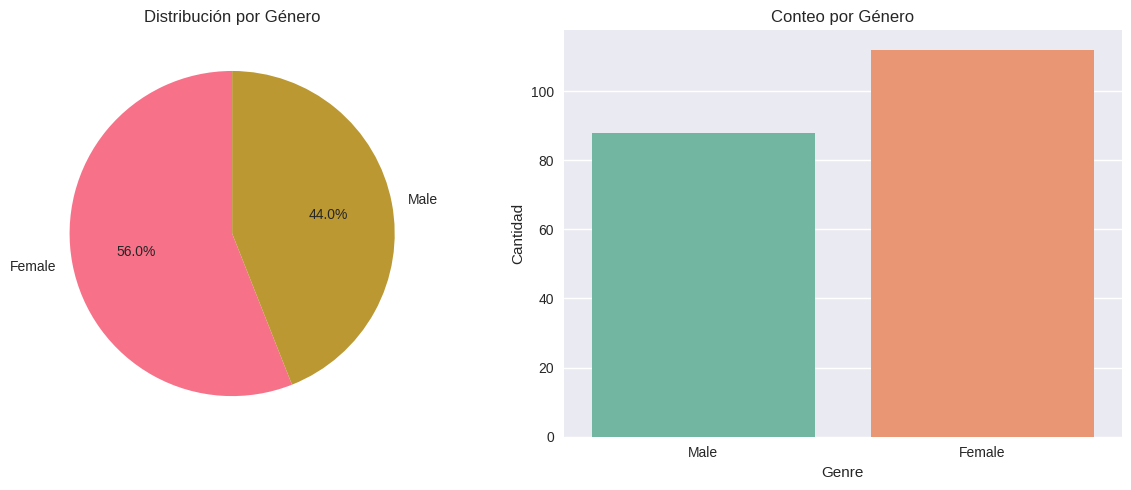

In [8]:

# An√°lisis de la variable categ√≥rica
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
genre_counts = df['Genre'].value_counts()
plt.pie(genre_counts.values, labels=genre_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribuci√≥n por G√©nero')

plt.subplot(1, 2, 2)
sns.countplot(data=df, x='Genre', palette='Set2')
plt.title('Conteo por G√©nero')
plt.ylabel('Cantidad')

plt.tight_layout()
plt.show()

Este gr√°fico ratifica lo que ya hemos evidanciado antes, hay mayor cantidad de mujeres en los datos recogidos, sin embargo no es una diferencia extrema


 Age:
  - L√≠mite inferior: -1.62
  - L√≠mite superior: 79.38
  - N√∫mero de outliers: 0

 Annual Income (k$):
  - L√≠mite inferior: -13.25
  - L√≠mite superior: 132.75
  - N√∫mero de outliers: 2
  - Porcentaje de outliers: 1.00%

 Spending Score (1-100):
  - L√≠mite inferior: -22.62
  - L√≠mite superior: 130.38
  - N√∫mero de outliers: 0


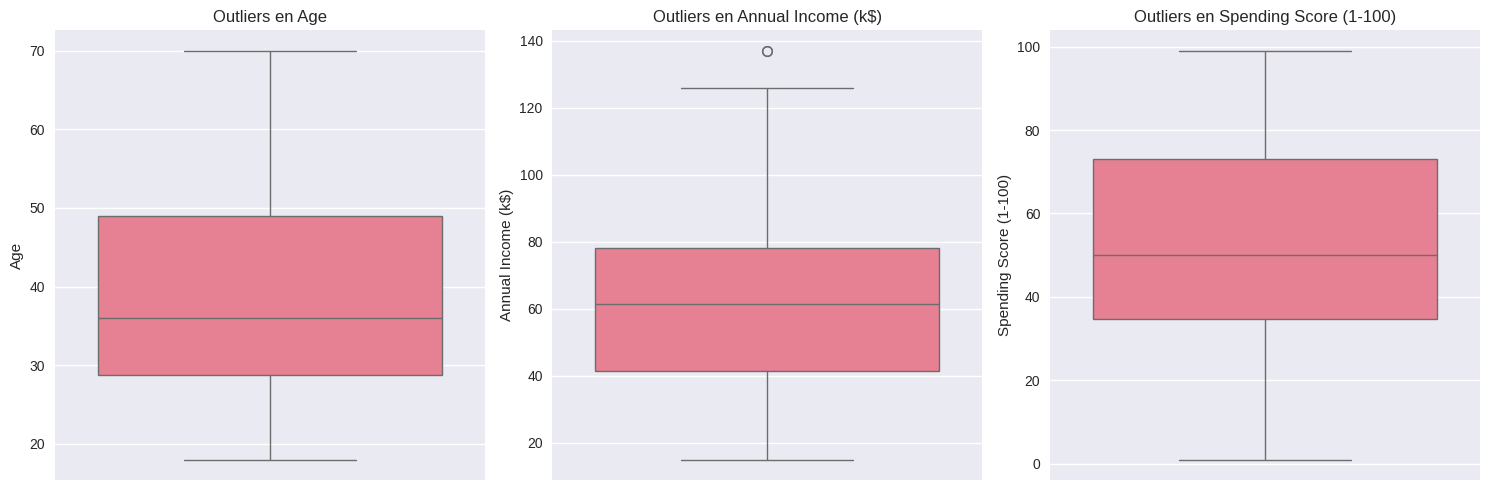

In [9]:
#AN√ÅLISIS DE OUTLIERS
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

numeric_columns = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

for col in numeric_columns:
    outliers, lower, upper = detect_outliers_iqr(df, col)
    print(f"\n {col}:")
    print(f"  - L√≠mite inferior: {lower:.2f}")
    print(f"  - L√≠mite superior: {upper:.2f}")
    print(f"  - N√∫mero de outliers: {len(outliers)}")
    if len(outliers) > 0:
        print(f"  - Porcentaje de outliers: {(len(outliers)/len(df)*100):.2f}%")

# Visualizaci√≥n de outliers
plt.figure(figsize=(15, 5))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(data=df, y=col)
    plt.title(f'Outliers en {col}')

plt.tight_layout()
plt.show()

No existen outlayers significativos

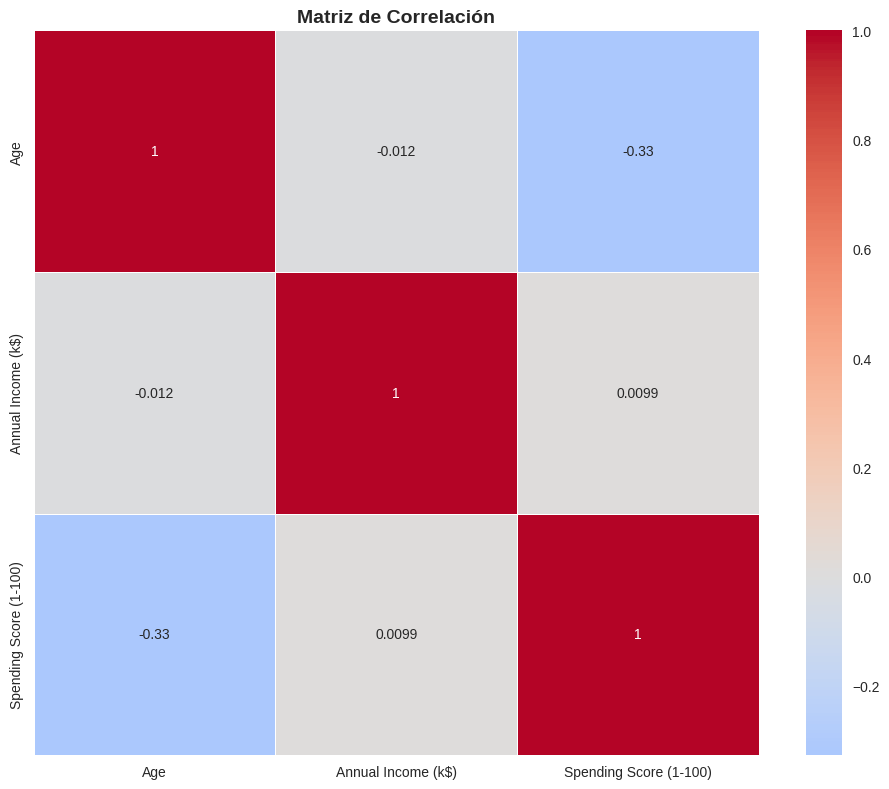


üìä Correlaciones:
                          Age  Annual Income (k$)  Spending Score (1-100)
Age                     1.000              -0.012                  -0.327
Annual Income (k$)     -0.012               1.000                   0.010
Spending Score (1-100) -0.327               0.010                   1.000


In [10]:
# AN√ÅLISIS DE CORRELACIONES

# Matriz de correlaci√≥n
plt.figure(figsize=(10, 8))
correlation_matrix = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Matriz de Correlaci√≥n', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nüìä Correlaciones:")
print(correlation_matrix.round(3))

En la matriz de correlaciones se puede ver que una de las relaciones m√°s significativas es la del Score de gastos y la edad (-0.32)

Los demas datos tienen baja corrrelaci√≥n entre s√≠ y con la variable objetivo

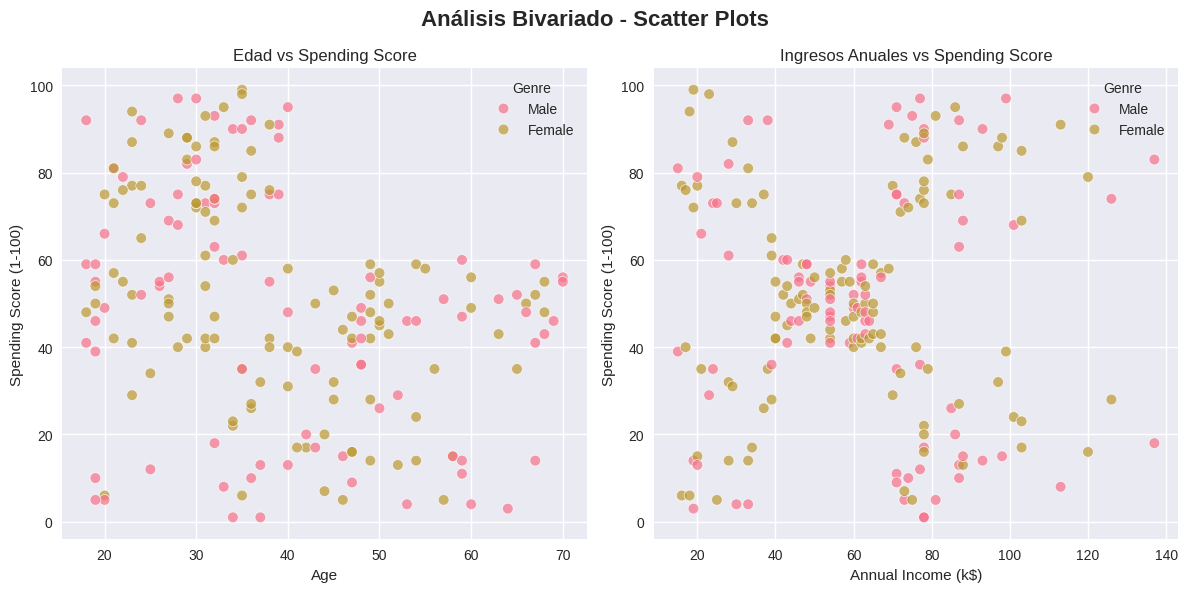

In [11]:


# Scatter plots
fig, axes = plt.subplots(1,2, figsize=(12,6))
fig.suptitle('An√°lisis Bivariado - Scatter Plots', fontsize=16, fontweight='bold')


# Age vs Spending Score
sns.scatterplot(data=df, x='Age', y='Spending Score (1-100)', hue='Genre', ax=axes[0], s=60, alpha=0.7)
axes[0].set_title('Edad vs Spending Score')

# Annual Income vs Spending Score
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Genre', ax=axes[1], s=60, alpha=0.7)
axes[1].set_title('Ingresos Anuales vs Spending Score')


plt.tight_layout()
plt.show()

Podemos evidenciar lo que ya nos arroj√≥ la matriz de correlaciones, no existe una correlaci√≥n lineal entre la edad y el promedio de gastos, ni en cuanto a los ingresos anuales.

Tampoco hay correlaciones entre promedio de ventas y g√©nero en cuanto al g√©nero.

Sin embargo se puede observar que hay **datos agrupados**  entorno a los ingresos anuales y el promedio de gastos como se observa en la segunda gr√°fica.

# Modelo

In [13]:
#eliminamos las todas las columnas excepto ingresos anuales e √≠ndice de gastos
df = df.drop(['Genre', 'Age', 'Age_Group', 'Income_Category', 'Spending_Category'], axis=1)

KeyError: "['Age_Group', 'Income_Category', 'Spending_Category'] not found in axis"


Datos escalados usando MinMaxScaler.
Primeras 5 filas de los datos escalados:
[[0.         0.3877551 ]
 [0.         0.81632653]
 [0.00819672 0.05102041]
 [0.00819672 0.7755102 ]
 [0.01639344 0.39795918]]


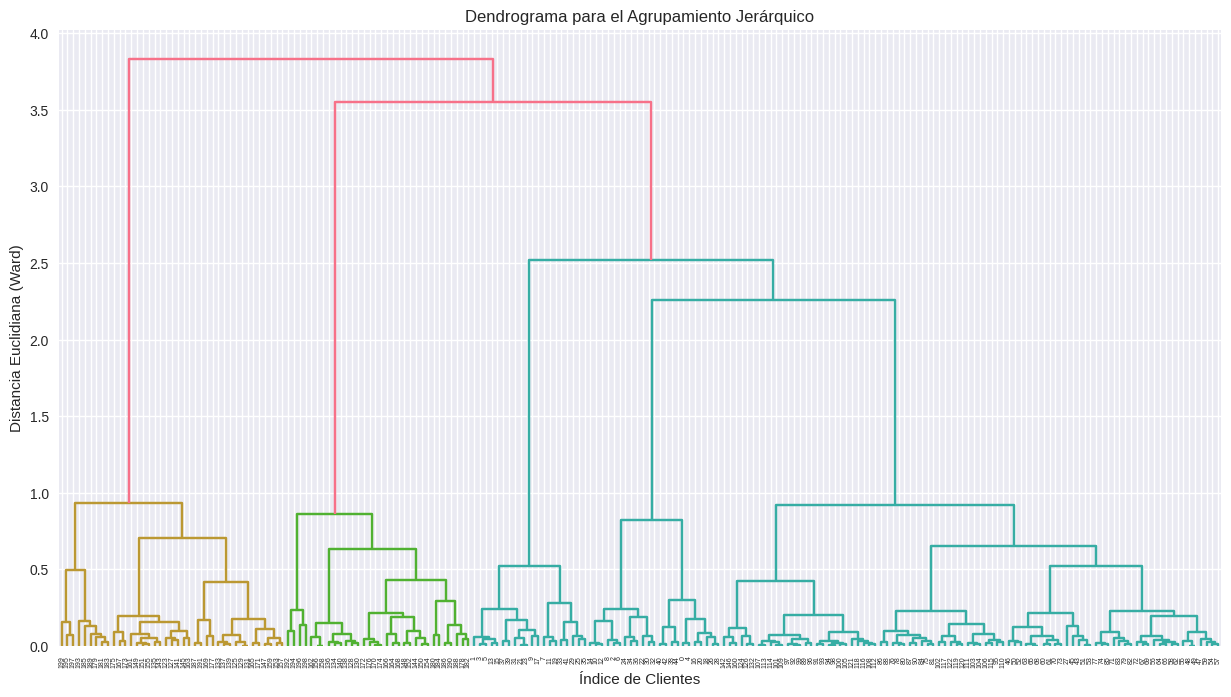

In [14]:
# Dendograma para generar un gr√°fico que muestra c√≥mo se agrupan los clientes de manera jer√°rquica.

X = df[['Annual Income (k$)', 'Spending Score (1-100)']]

# Escalamos los datos usando min-max scaler

from sklearn.preprocessing import MinMaxScaler


# Escalar los datos usando MinMaxScaler
scaler_minmax = MinMaxScaler()
X_scaled = scaler_minmax.fit_transform(X)

print("\nDatos escalados usando MinMaxScaler.")
print("Primeras 5 filas de los datos escalados:")
print(X_scaled[:5])


# Generar el dendrograma

# Utilizamos la distancia euclidiana ('euclidean') y el criterio de enlace 'ward'
linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(15, 8))
dendrogram(linked, orientation='top')
plt.title('Dendrograma para el Agrupamiento Jer√°rquico')
plt.xlabel('√çndice de Clientes')
plt.ylabel('Distancia Euclidiana (Ward)')
plt.show()


Si trazamos una l√≠nea horizontal a la altura entre 4 y 6, interceptar√≠a **5** l√≠neas verticales sin cruzar ninguna l√≠nea horizontal.

Esta ser√≠a la divisi√≥n √≥ptima.

*A esta altura, los grupos estar√°n bien diferenciados
Captura la estructura natural de los datos
Evita tanto el sub-agrupamiento como el sobre-agrupamiento
Las distancias intra-cl√∫ster son menores que las inter-cl√∫ster*

#Modelo

In [15]:
# Seleccionamos las variables relevantes para el clustering
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]


In [16]:
 #rAgrupamiento jer√°rquico aglomerativo.

from sklearn.cluster import AgglomerativeClustering

modelo_hclust_ward = AgglomerativeClustering(
                            linkage  = 'ward',
                            distance_threshold = None, # Set to None when n_clusters is specified
                            n_clusters         = 5
                     )
modelo_hclust_ward.fit(X=X_scaled)
# AgglomerativeClustering(distance_threshold=0, n_clusters=5) # This line is not needed

AgglomerativeClustering(n_clusters=5)


 Cl√∫steres asignados a cada cliente.

Distribuci√≥n de clientes por cl√∫ster:
Cluster
0    39
1    86
2    32
3    20
4    23
Name: count, dtype: int64


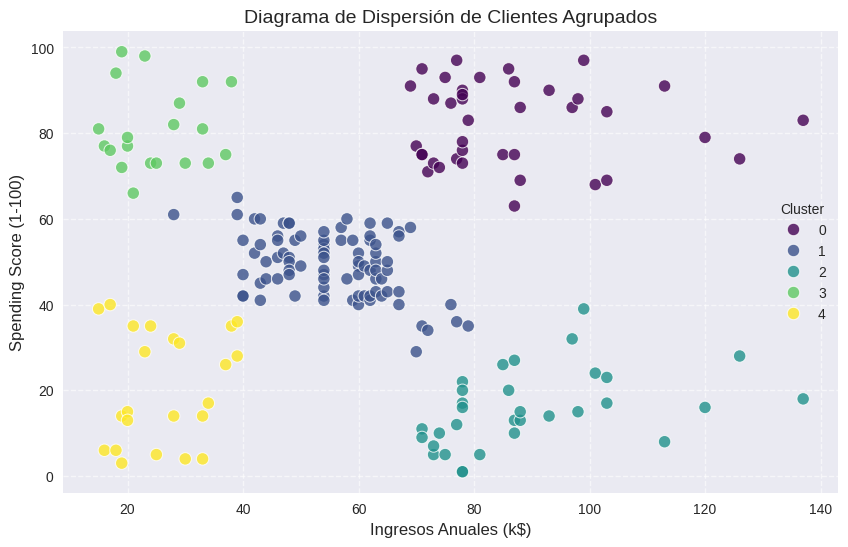

         Annual Income (k$)  Spending Score (1-100)
Cluster                                            
0                     86.54                   82.13
1                     55.49                   49.27
2                     89.41                   15.59
3                     24.95                   81.00
4                     26.30                   20.91


In [20]:
# Diagrama de dispersi√≥n para visualizar los diferentes grupos de clientes.

# Agregar las etiquetas de los cl√∫steres al DataFrame original
df['Cluster'] = modelo_hclust_ward.labels_

print("\n Cl√∫steres asignados a cada cliente.")
print("\nDistribuci√≥n de clientes por cl√∫ster:")
print(df['Cluster'].value_counts().sort_index())

# Visualizar los cl√∫steres en un diagrama de dispersi√≥n
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)',
                hue='Cluster', palette='viridis', s=80, alpha=0.8, legend='full')

plt.title('Diagrama de Dispersi√≥n de Clientes Agrupados', fontsize=14)
plt.xlabel('Ingresos Anuales (k$)', fontsize=12)
plt.ylabel('Spending Score (1-100)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# An√°lisis de los cl√∫steres

cluster_summary = df.groupby('Cluster')[['Annual Income (k$)', 'Spending Score (1-100)']].mean().round(2)
print(cluster_summary)



Podemos observar que:

Cl√∫ster 0: Ingresos Medios->Gasto Medio

Cl√∫ster 1: Ingresos Altos **pero** Gasto Bajo

Cl√∫ster 2: Ingresos Bajos ->Gasto Bajo

Cl√∫ster 3:  Ingresos Bajos **pero** Gasto Alto

Cl√∫ster 4: Ingresos Altos-> Gasto Alto (potencial)

La mayor parte de los clientes se encuentran en el Cl√∫ster 1:

Ingresos Altos **pero** Gasto Bajo

¬øTaca√±os?